# Разработка A/B-тестирования и анализ результатов

## Постановка задачи

Наш заказчик - развлекательное приложение с функцией «бесконечной» ленты.\
Команда разработчиков создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя.\
Нужно рассчитать параметры A/B-теста, оценить корректность его проведения и проанализировать результаты эксперимента.

**Ожидаемые метрики и эффекты A/B-теста:**
- Основная метрика — доля сессий с глубоким просмотром (4+ страниц).\
Ожидаем рост показателя в группе с новым алгоритмом.

- Дополнительные метрики — среднее количество страниц за сессию, конверсия в регистрацию, частота возвратов.\
Они помогут оценить, как именно изменилось поведение пользователей.

## Описание данных

Мы будем работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. 
- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14.
- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. 

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).

## Содержимое проекта
1. Работа с историческими данными.
2. Подготовка к тесту.
3. Мониторинг А/В-теста.
4. Проверка результатов А/В-теста.

### 1. Работа с историческими данными `sessions_project_history.csv`

#### 1.1. Загрузка исторических данных
На первом этапе поработаем с историческими данными приложения:

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from math import ceil

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
# Выгружаем данные с историческими данными о сессиях пользователей в переменную sessions_history
sessions_history = pd.read_csv('/datasets/sessions_project_history.csv')

In [3]:
# Выводим первые 5 строк полученного датафрейма на экран
sessions_history.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [4]:
# Выводим информацию о датафрейме
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


Итого датасет sessions_project_history.csv содержит 9 столбцов и 435924 строку, в которых представлена информация с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. 
- Пропусков в столбцах нет
- Значения в столбцах соответствуют своему описанию.
- Столбцы с датами: `session_date`, `session_start_ts`, `install_date` приведем к нужному формату `datetime64`

In [5]:
sessions_history['session_start_ts'] = pd.to_datetime(sessions_history['session_start_ts'])
sessions_history['session_date'] = pd.to_datetime(sessions_history['session_date'])
sessions_history['install_date'] = pd.to_datetime(sessions_history['install_date'])
sessions_history.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   user_id            435924 non-null  object        
 1   session_id         435924 non-null  object        
 2   session_date       435924 non-null  datetime64[ns]
 3   session_start_ts   435924 non-null  datetime64[ns]
 4   install_date       435924 non-null  datetime64[ns]
 5   session_number     435924 non-null  int64         
 6   registration_flag  435924 non-null  int64         
 7   page_counter       435924 non-null  int64         
 8   region             435924 non-null  object        
 9   device             435924 non-null  object        
dtypes: datetime64[ns](3), int64(3), object(4)
memory usage: 33.3+ MB


Преобразования прошли успешно. Проверим данные на дубликаты.

In [6]:
sessions_history.duplicated().sum()

0

#### 1.2. Знакомство с данными

Для каждого уникального пользователя user_id рассчитаем количество уникальных сессий session_id. Далее выведим на экран все данные из таблицы sessions_history для одного пользователя с наибольшим количеством сессий.\
Изучим таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.

In [7]:
# Для каждого уникального пользователя рассчитаем количество уникальных сессий
df_users = sessions_history.groupby('user_id')['session_id'].nunique()
df_users

user_id
00005FB6A13A6FBE    2
0000B15A18D77ED9    3
0000C4E3A4A571A9    2
000293FAF9E67A81    4
00029C5AE889A6C3    2
                   ..
FFFCDE7746148710    4
FFFDD413285E753F    3
FFFECBA0F2578AB0    2
FFFEDB68228B5F21    5
FFFF4228DF580C3B    3
Name: session_id, Length: 134039, dtype: int64

In [8]:
# Выведем на экран все данные из таблицы sessions_history для одного пользователя с наибольшим количеством сессий
max_df_users = df_users.idxmax()
max_users = sessions_history[sessions_history['user_id'] == max_df_users]
max_users

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


Выводы из данных самого активного пользователя:
- У пользователя было 10 сессий за 12 дней (с 14 по 25 августа). Пропуски были 21 и 23 августа.
- Пользователь не зарегистрирован.
- Дата установки совпадает с первой сессией.
- Пользователь активен во второй половине дня с 13:23 по 19:53.
- Регион пользователя CIS (СНГ).
- Устройство android - мобильный пользователь.

#### 1.3. Анализ числа регистраций

Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, расчитаем и визуализируем как менялось число регистраций в приложении за время его существования.

In [9]:
# Количество уникальных и зарегистрированных пользователей
day_stats = sessions_history.groupby('session_date').agg(
total_users=('user_id', 'nunique'), 
registration_users=('registration_flag', 'sum')).reset_index().sort_values('session_date')
day_stats.head(10)

,session_date,total_users,registration_users
0,2025-08-11,3919,169
1,2025-08-12,6056,336
2,2025-08-13,8489,464
3,2025-08-14,10321,625
4,2025-08-15,14065,840
5,2025-08-16,12205,916
6,2025-08-17,11200,833
7,2025-08-18,10839,860
8,2025-08-19,12118,831
9,2025-08-20,13514,1008


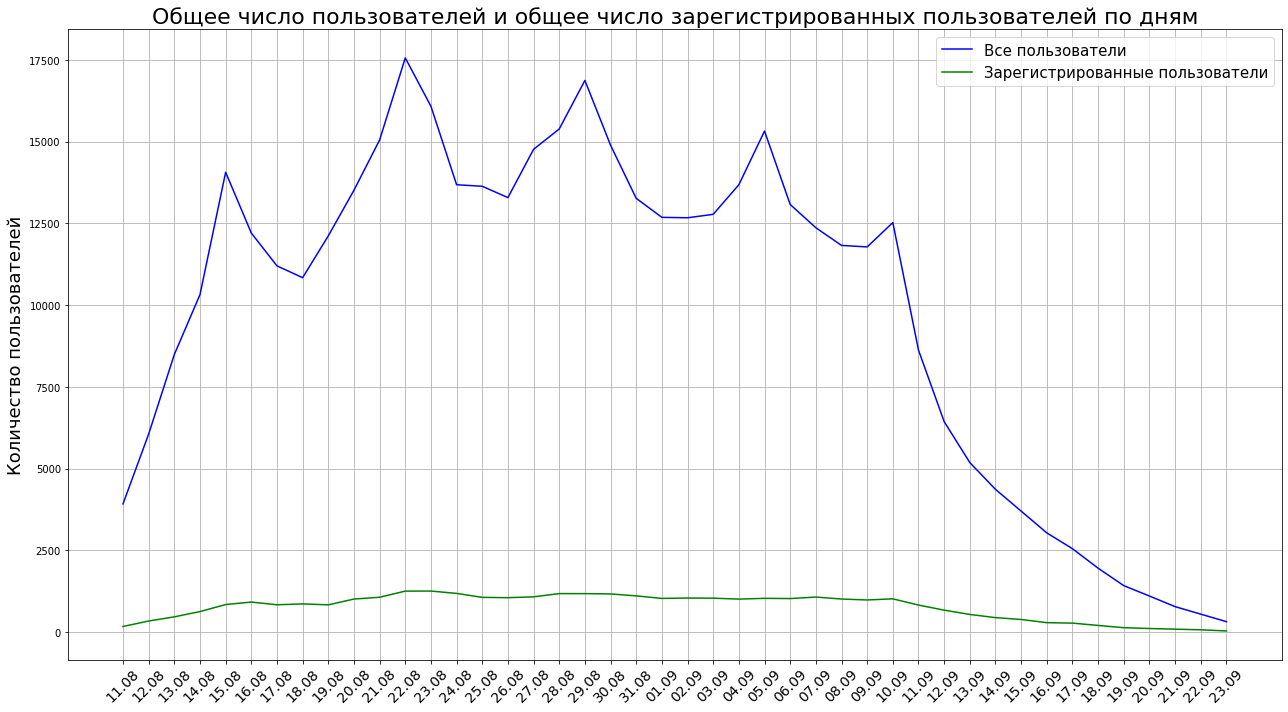

In [10]:
# Линейный график общего числа пользователей и общего числа зарегистрированных пользователей по дням
plt.figure(figsize=(18, 10))

# График общего числа пользователей
plt.plot(day_stats['session_date'], 
         day_stats['total_users'], 
         label='Все пользователи',
         color='blue')

# График зарегистрированных пользователей
plt.plot(day_stats['session_date'], 
         day_stats['registration_users'], 
         label='Зарегистрированные пользователи',   
         color='green')

# Настройки графика
plt.title('Общее число пользователей и общее число зарегистрированных пользователей по дням', fontsize=22)
plt.xlabel('')
plt.ylabel('Количество пользователей', fontsize=18)
plt.legend(fontsize=15)
plt.grid(True)
plt.xticks(day_stats['session_date'], 
           [d.strftime('%d.%m') for d in day_stats['session_date']],
           rotation=45, fontsize=14)
plt.tight_layout()
plt.show()

- По графику мы наблюдаем, что большинство пользователей остаются незарегистрированными. Нужно упростить прооцесс регистрации или добавить мотивацию.
- Мы видим 5 дней с максимальным числом пользователей. Это 15 августа (более 12500), 22 августа (17500 пользователей - пик) и 29  августа(более 15000), 5 сентября (15000 пользователей) и 10 сентября (12500). После 10 сентября мы видим резкий спад числа зарегистрированных и незарегистрированных пользователей. Нужно уточнить возможные причины такого резкого спада. Возможно, это технический проблемы или сезонность или завершение промо-кампаний.

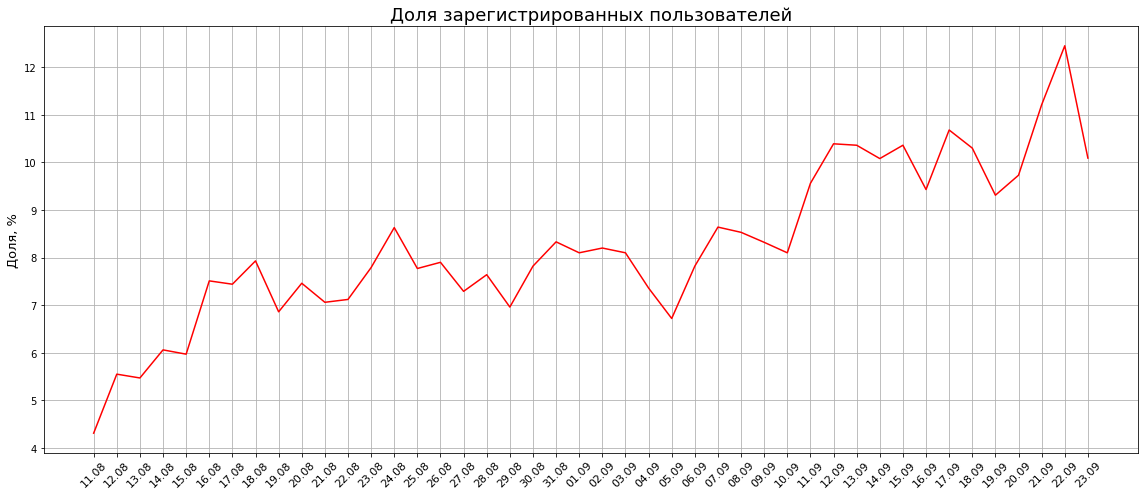

In [11]:
# Линейный график доли зарегистрированных пользователей от всех пользователей по дням
day_stats['registration_rate'] = round(day_stats['registration_users'] / day_stats['total_users'] *100, 2)
plt.figure(figsize=(16, 7))

plt.plot(day_stats['session_date'], day_stats['registration_rate'],color='red')

plt.title('Доля зарегистрированных пользователей', fontsize=18)
plt.xlabel('',)
plt.ylabel('Доля, %', fontsize=13)
plt.grid(True)

plt.xticks(day_stats['session_date'], 
           [d.strftime('%d.%m') for d in day_stats['session_date']],
           rotation=45, fontsize=11)

plt.tight_layout()
plt.show()

Тенденция неоднозначная: при общем спаде трафика конверсия в регистрацию немного выросла. Готовность к регистрации повысилась, но общий охват уменьшился- это может быть связано с уменьшением количества наблюдений к концу периода.

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку. Расчитаем и визуализируем число просмотренных страниц в приложении.

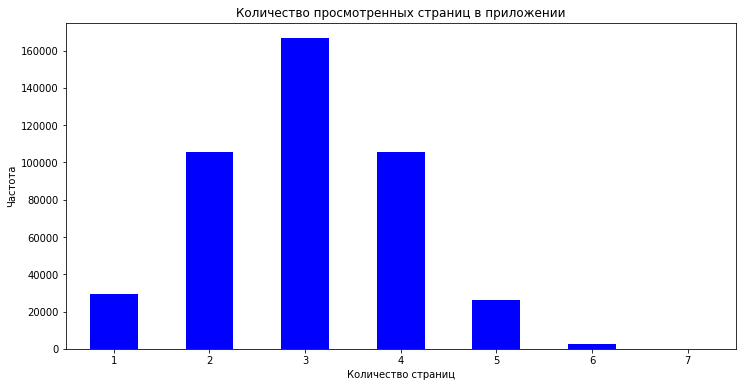

In [12]:
page_counts = sessions_history['page_counter'].value_counts().sort_index()

plt.figure(figsize=(12, 6))

page_counts.plot(kind='bar',
                 title='Количество просмотренных страниц в приложении',
                 legend=False,
                 ylabel='Частота',
                 xlabel='Количество страниц',
                 rot=0,
                 color='blue')
plt.show()

- Пик приходится на 3 страницы (160 000 тыс. сессий). 
- 2 и 4 страницы также популярны (около 140 тыс. и 120 тыс.) 
- Сессии с 1 или 5 страниц значительно меньше.
Пользователи чаще всего просматривают 2-4 страницы за сессию, что говорит о средней глубине вовлечения.

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.\
Построим график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.

In [13]:
# Создаем новый столбец good_session
sessions_history['good_session'] = (sessions_history['page_counter'] >= 4).astype(int)

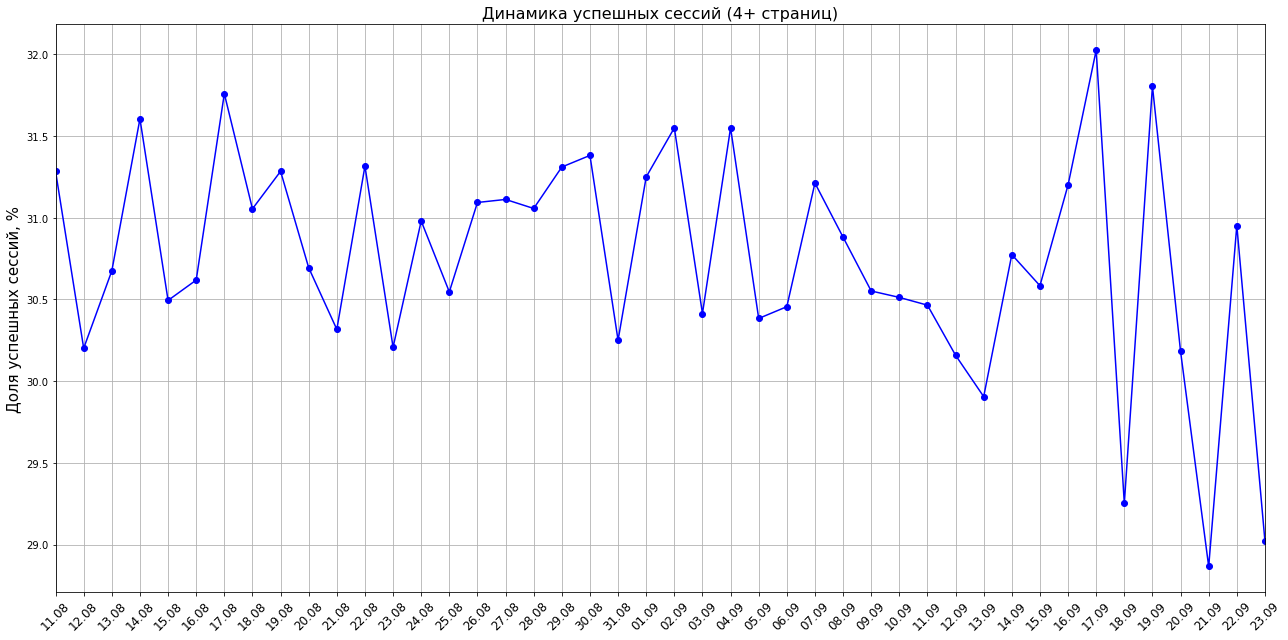

In [14]:
# Строим график со средним значением доли успешных сессий
part_session = sessions_history.groupby('session_date')['good_session'].mean() * 100

plt.figure(figsize=(18, 9))
part_session.plot(kind='line', marker='o', color='blue')

plt.title('Динамика успешных сессий (4+ страниц)', fontsize=16)
plt.xlabel('')
plt.ylabel('Доля успешных сессий, %', fontsize=15)
plt.grid(True)
plt.xticks(part_session.index, 
           [d.strftime('%d.%m') for d in part_session.index],
           rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

- Доля успешных сессий (4+ страниц) колеблется в диапазоне от 27% до 32%.
- Метрика нестабильна день ото дня, но общий уровень сохраняется.

### 2. Подготовка к тесту
При планировании теста проделаем несколько важных шагов:

- Сформулируем нулевую и альтернативную гипотезы

- Определимся с целевой метрикой.

- Рассчитаем необходимый размер выборки.

- Исходя из текущих значений трафика рассчитаем необходимую длительность проведения теста.

#### 2.1 Формулировка нулевой и альтернативной гипотез

Нулевая гипотеза:
- Новая рекомендательная система не влияет на вовлеченность пользователей. Доля успешных сессий (4+ страниц) в группе А (старый алгоритм) и в группе В (новый алгоритм) не различается.

Альтернативная гипотеза:
- Новая рекомендательная система увеличивает вовлеченность пользователей. Доля успешных сессий в группе В (новый алгоритм) выше, чем в группе А (старый алгоритм).
Односторонняя правая гипотеза, так как ожидается улучшение.


#### 2.2. Расчёт размера выборки

In [15]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
p = 0.3 # Базовый уровень доли
mde = 0.03 * p  # Минимальный детектируемый эффект
p1 = p
effect_size = proportion_effectsize(p1, p1 + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### 2.3. Расчёт длительности A/B-теста

In [16]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = round(sessions_history.groupby('session_date')['user_id'].nunique().mean())

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil((sample_size * 2) / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 9 дней


Допустимый минимальный срок составит 9 дней, в нашем случае тест длится - 20 дней, за счёт чего общее число участников увеличивается. Поэтому мощность теста остаётся высокой — 99.97%. Это значит, что вероятность не заметить реальный эффект крайне мала.

### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе убедимся, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считаем и сохраним в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитаем и выведим на экран процентную разницу в количестве пользователей в группах A и B. Построим визуализацию, на которой будет видно возможное различие двух групп.

Для расчёта процентной разницы воспользуемся формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [17]:
# Сохраним данные за первый день A/B теста в датафрейм sessions_test_part
sessions_test_part = pd.read_csv('/datasets/sessions_project_test_part.csv')

In [18]:
# Выводим информацию о датафрейме
sessions_test_part.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3130 entries, 0 to 3129
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            3130 non-null   object
 1   session_id         3130 non-null   object
 2   session_date       3130 non-null   object
 3   session_start_ts   3130 non-null   object
 4   install_date       3130 non-null   object
 5   session_number     3130 non-null   int64 
 6   registration_flag  3130 non-null   int64 
 7   page_counter       3130 non-null   int64 
 8   region             3130 non-null   object
 9   device             3130 non-null   object
 10  test_group         3130 non-null   object
dtypes: int64(3), object(8)
memory usage: 269.1+ KB


- Мы имеем 11 столбцов, 3130 строк.
- Пропусков в столбцах нет.
- Столбцы с датами: session_date, session_start_ts, install_date приведем к нужному формату datetime64.

In [19]:
sessions_test_part['session_start_ts'] = pd.to_datetime(sessions_test_part['session_start_ts'])
sessions_test_part['session_date'] = pd.to_datetime(sessions_test_part['session_date'])
sessions_test_part['install_date'] = pd.to_datetime(sessions_test_part['install_date'])
sessions_test_part.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3130 entries, 0 to 3129
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            3130 non-null   object        
 1   session_id         3130 non-null   object        
 2   session_date       3130 non-null   datetime64[ns]
 3   session_start_ts   3130 non-null   datetime64[ns]
 4   install_date       3130 non-null   datetime64[ns]
 5   session_number     3130 non-null   int64         
 6   registration_flag  3130 non-null   int64         
 7   page_counter       3130 non-null   int64         
 8   region             3130 non-null   object        
 9   device             3130 non-null   object        
 10  test_group         3130 non-null   object        
dtypes: datetime64[ns](3), int64(3), object(5)
memory usage: 269.1+ KB


Преобразования прошли успешно.

In [20]:
# Посмотрим, какие группы встречаются в эксперименте
sessions_test_part['test_group'].unique() 

array(['B', 'A'], dtype=object)

In [21]:
# Рассчитаем количество уникальных пользователей в каждой группе.
sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique(), sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].nunique() 

(1477, 1466)

In [22]:
# Посмотрим в каком процентном соотношении они находятся
part_gr = 100 * sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique() / sessions_test_part['user_id'].nunique(), 100 * sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].nunique() / sessions_test_part['user_id'].nunique() 
part_gr

(50.18688413183826, 49.81311586816174)

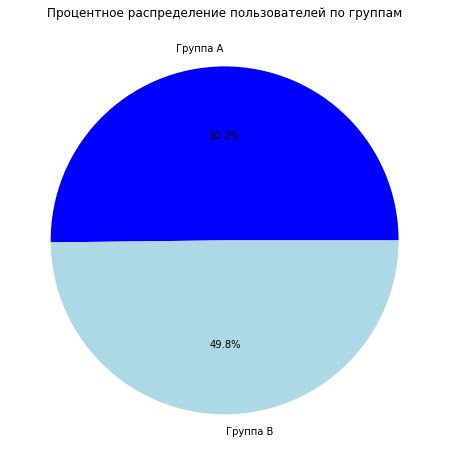

In [23]:
# Построим круговую диаграмму для визуализации
part_gr = (50.18688413183826, 49.81311586816174)
plt.figure(figsize=(8, 8))
plt.pie(part_gr, 
        labels=['Группа A', 'Группа B'], 
        autopct='%1.1f%%',
        colors=['blue', 'lightblue'])

plt.title('Процентное распределение пользователей по группам')
plt.show()

#### 3.2. Проверка пересечений пользователей

In [24]:
users_a = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id']
users_b = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id']

intersection = list(set(users_a) & set(users_b))
print(intersection) 

[]


Результат [ ] означает, что пересечений пользователей в группах нет.

#### 3.3. Равномерность разделения пользователей по устройствам

Построим две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

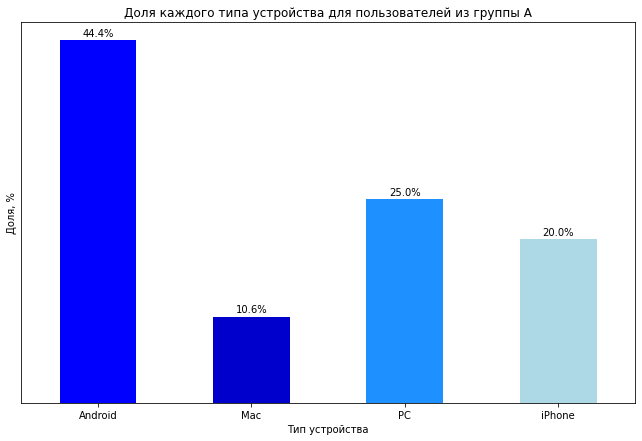

In [25]:
# Строим столбачтую диаграмму для доли каждого типа устройства для пользователей из группы А
device_group_a = sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('device')['user_id'].nunique()
device_group_a = device_group_a / device_group_a.sum() * 100
color_palette = ['blue', 'mediumblue', 'dodgerblue', 'lightblue']
device_group_a.plot(kind='bar',
                title='Доля каждого типа устройства для пользователей из группы A',
                legend=False,
                ylabel='Доля, %',
                xlabel='Тип устройства',
                rot=0,
                color=color_palette,
                figsize=(11, 7))
for i, value in enumerate(device_group_a.values):
    plt.text(i, value + 0.5, f'{value:.1f}%', ha='center')
plt.yticks([])
plt.show()

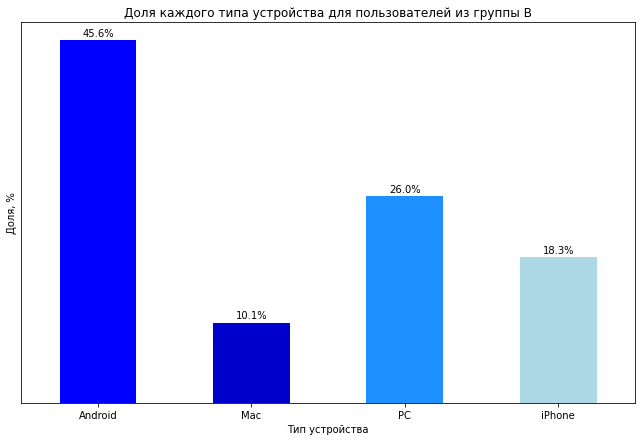

In [26]:
# Строим столбачтую диаграмму для доли каждого типа устройства для пользователей из группы В
device_group_b = sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('device')['user_id'].nunique()
device_group_b = device_group_b / device_group_b.sum() * 100
color_palette = ['blue', 'mediumblue', 'dodgerblue', 'lightblue']
device_group_b.plot(kind='bar',
                title='Доля каждого типа устройства для пользователей из группы B',
                legend=False,
                ylabel='Доля, %',
                xlabel='Тип устройства',
                rot=0,
                color=color_palette,
                figsize=(11, 7))
for i, value in enumerate(device_group_b.values):
    plt.text(i, value + 0.5, f'{value:.1f}%', ha='center')
plt.yticks([])
plt.show()

- Доля устройств в группах А и В практически идентична. Различия между группами незначительная (0.5 - 1.7%).
Это говорит об однородности пользователей и схожие условия входа для группы по типам устройств.

#### 3.4. Равномерность распределения пользователей по регионам

Построим две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

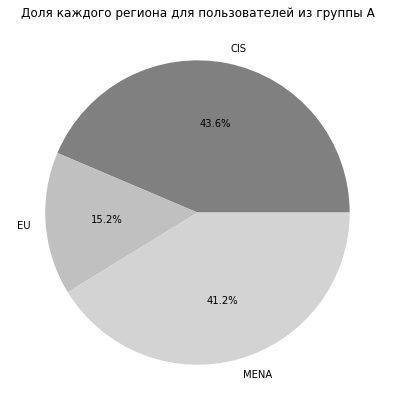

In [27]:
# Построим круговую диаграмму для доли каждого региона для пользователей из группы A
region_group_a = sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('region')['user_id'].nunique()
region_group_a = region_group_a / region_group_a.sum() * 100
color_palette_1 = ['gray', 'silver', 'lightgray']
region_group_a.plot(kind='pie',
                title='Доля каждого региона для пользователей из группы A',
                autopct='%1.1f%%',
                legend=False,
                colors=color_palette_1,
                figsize=(11, 7))
plt.ylabel('')
plt.show()

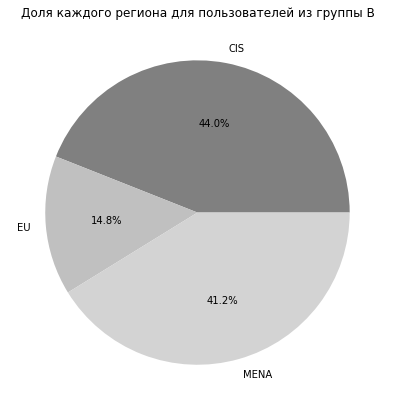

In [28]:
# Построим круговую диаграмму для доли каждого региона для пользователей из группы B
region_group_b = sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('region')['user_id'].nunique()
region_group_b = region_group_b / region_group_b.sum() * 100
color_palette_1 = ['gray', 'silver', 'lightgray']
region_group_b.plot(kind='pie',
                title='Доля каждого региона для пользователей из группы В',
                autopct='%1.1f%%',
                legend=False,
                colors=color_palette_1,
                figsize=(11, 7))
plt.ylabel('')
plt.show()

Доля каждого региона для пользователей из группы A и В практически идентична. Различия между группами незначительная (0.4 - 1.4%). 
Это говорит об однородности пользователей и схожие условия входа для группы по регионам.

#### 3.5. Вывод после проверки A/B-теста

- Размер групп по количеству пользователей практически равны (разница в 0.04%)
- Пересечений между пользователями нет - выборки независимы.
- Сохраняется равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.
- Из всего вышеперечисленного, мы можем сделать вывод, что  A/B-тест проходит корректно.

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у нас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считаем и сохраним в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей

In [29]:
# Сохраним данными за весь период проведения A/B-теста в датафрйем sessions_test
sessions_test = pd.read_csv('/datasets/sessions_project_test.csv')

In [30]:
# Выводим информацию о датафрейме
sessions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100005 entries, 0 to 100004
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            100005 non-null  object
 1   session_id         100005 non-null  object
 2   session_date       100005 non-null  object
 3   session_start_ts   100005 non-null  object
 4   install_date       100005 non-null  object
 5   session_number     100005 non-null  int64 
 6   registration_flag  100005 non-null  int64 
 7   page_counter       100005 non-null  int64 
 8   region             100005 non-null  object
 9   device             100005 non-null  object
 10  test_group         100005 non-null  object
dtypes: int64(3), object(8)
memory usage: 8.4+ MB


- Мы имеем 11 столбцов, 100005 строк.
- Пропусков в столбцах нет.
- Столбцы с датами: session_date, session_start_ts, install_date приведем к нужному формату datetime64.

In [31]:
sessions_test['session_start_ts'] = pd.to_datetime(sessions_test['session_start_ts'])
sessions_test['session_date'] = pd.to_datetime(sessions_test['session_date'])
sessions_test['install_date'] = pd.to_datetime(sessions_test['install_date'])
sessions_test.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100005 entries, 0 to 100004
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   user_id            100005 non-null  object        
 1   session_id         100005 non-null  object        
 2   session_date       100005 non-null  datetime64[ns]
 3   session_start_ts   100005 non-null  datetime64[ns]
 4   install_date       100005 non-null  datetime64[ns]
 5   session_number     100005 non-null  int64         
 6   registration_flag  100005 non-null  int64         
 7   page_counter       100005 non-null  int64         
 8   region             100005 non-null  object        
 9   device             100005 non-null  object        
 10  test_group         100005 non-null  object        
dtypes: datetime64[ns](3), int64(3), object(5)
memory usage: 8.4+ MB


Преобразования прошли успешно.

In [32]:
# Создаем новый столбец good_session
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype(int)

#### 4.2. Проверка корректности результатов теста

- Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп.
- Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми. - - - Используем статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

В качестве ответа выведим на экран полученное значение p-value и интерпретируем его.

Сформулируем гипотезу перед статистическим тестом:
- H₀ (нулевая гипотеза) — количество уникальных дневных сессий не различается между тестовой и контрольной группами.
- H₁ (альтернативная гипотеза) — количество уникальных дневных сессий различается между тестовой и контрольной группами.

In [33]:
# Количество уникальных сессий для каждого дня и обеих тестовых групп
df_users = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().reset_index()

In [34]:
# Cтатистический тест о равенстве средних двух выборок
group_a = df_users[df_users['test_group'] == 'A']['session_id']
group_b = df_users[df_users['test_group'] == 'B']['session_id']

result = ttest_ind(group_a, group_b, alternative='two-sided')
print(f'p_value = {result}')
      
if result.pvalue > 0.05:
    print('Количество уникальных дневных сессий в двух выборках не различается')
else:
    print('Количество уникальных дневных сессий в двух выборках различается')

p_value = Ttest_indResult(statistic=-0.07802281548251853, pvalue=0.938219304859116)
Количество уникальных дневных сессий в двух выборках не различается


#### 4.3. Сравнение доли успешных сессий

Проанализируем ключевую метрику — доли успешных сессий.

In [35]:
part_session_a = sessions_test[sessions_test['test_group'] == 'A']['good_session'].mean()
part_session_b = sessions_test[sessions_test['test_group'] == 'B']['good_session'].mean()
diff = part_session_b - part_session_a
print(f'Доля успешных сессий для выборки А - {part_session_a:.2%}')
print(f'Доля успешных сессий для выборки B - {part_session_b:.2%}')    
print(f'Разница в доли успешных сессий между выборками А и В - {diff:.1%}')

Доля успешных сессий для выборки А - 30.77%
Доля успешных сессий для выборки B - 31.83%
Разница в доли успешных сессий между выборками А и В - 1.1%


#### 4.4. Расчитаем насколько статистически значимо изменение ключевой метрики

In [36]:
group_a = sessions_test[sessions_test['test_group'] == 'A']
group_b = sessions_test[sessions_test['test_group'] == 'B']

success_a = group_a['good_session'].sum()
success_b = group_b['good_session'].sum()

total_a = group_a.shape[0]
total_b = group_b.shape[0]

z_stat, p_value = proportions_ztest(
    count=[success_b, success_a],
    nobs=[total_b, total_a],
    alternative='larger')

print(f'Доля успешных сессий в группе A: {success_a/total_a:.2%}')
print(f'Доля успешных сессий в группе B: {success_b/total_b:.2%}')
print(f'p-value = {p_value}')

if p_value > 0.05:
    print('Нулевая гипотеза находит подтверждение')
    print('Интерпретация: Новый алгоритм рекомендаций не показывает более интересный контент для каждого пользователя')
else:
    print('Нулевая гипотеза не находит подтверждение')
    print('Интерпретация: Новый алгоритм рекомендаций показывает более интересный контент для каждого пользователя')

Доля успешных сессий в группе A: 30.77%
Доля успешных сессий в группе B: 31.83%
p-value = 0.0001574739988036123
Нулевая гипотеза не находит подтверждение
Интерпретация: Новый алгоритм рекомендаций показывает более интересный контент для каждого пользователя


#### 4.5. Вывод по результатам A/B-эксперимента

Мы рассчитали параметры A/B-теста, который позволил проверить гипотезу, что новый алгоритм рекомендаций будет показывать более интересный контент для каждого пользователя. 
- Необходимый размер выборки для каждой группы: 41040 пользователей
- Количество уникальных пользователей в группе А - 1477 и В - 1466 пользователей (50.2% и 49.8%)
- Рассчитанная длительность A/B-теста при текущем уровене трафика составит 9 дней, но в нашем случае A/B тест продлился - 20 дней. Поэтому мощность теста остаётся высокой — 99.97%.
- Мы выявили, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной.
- После проведенного статистического теста, мы рассчитали, что p-value = 0.0001574739988036123. Это означает, что новый алгоритм рекомендаций показывает более интересный контент для каждого пользователя.